# Beyond Shortcuts: DenseNet Architecture

You've already built a solid foundation with linear models where data flows sequentially through a stack of layers. Now, you'll explore a more advanced design pattern that gives you direct control over the flow of information through your network. You've seen how ResNet's skip connections help with training deep networks by preserving the gradient. This lab takes that idea a step further by asking a powerful question: instead of reusing just one previous layer's output, what if a layer could access the features from *all* preceding layers? 

This is the core philosophy behind **DenseNet**, an architecture designed for maximum feature reuse and parameter efficiency. By building this model from its fundamental components, you'll gain a deep, practical understanding of how modern architectures are designed to solve complex problems.

In this lab, you will:

* Construct a custom **DenseNet** from its core building blocks: the `DenseLayer`, the `DenseBlock`, and the `TransitionLayer`.

* Train your custom-built model from scratch on a challenging land use dataset with many classes but few images per class.

* Apply the professional workflow of **transfer learning**, using a pre-trained `densenet121` to perform feature extraction.

* Compare the from-scratch and feature-extraction approaches to see firsthand the dramatic efficiency and performance gains of leveraging pre-trained models.

Let's get started!

## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import torchinfo

import helper_utils

# Set seed
SEED = 42

In [2]:
# Setup device priority: CUDA -> MPS -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

Using device: CUDA


## Upping the Ante: A Land Use Challenge

You have already successfully trained a model to classify broad landscapes from an aerial perspective. Now, you will take on a more intricate task: moving from identifying general scenery to classifying specific land use. This requires a higher level of precision. Your model will not just find a residential zone; it will need to learn the subtle visual cues that distinguish between varying housing densities, different forms of architectural construction, and the unique textural patterns that separate a parking lot from a mobile home park or harbor.

This new task comes with a distinct set of challenges. The [UC Merced Land Use dataset](https://www.kaggle.com/datasets/zeadomar/uc-mercedland) presents you with:

* **More Granular Categories**: You will be classifying **21 distinct classes**, a significant increase in complexity that demands a more discerning model.

* **Far Less Data Per Class**: The dataset is constructed with only **100 images for each category**. This scarcity presents a realistic professional challenge, demanding an architecture so efficient that it can deliver strong performance despite the limited data.

A look at the directory structure reveals the granularity of the challenge ahead:

```
./UCMerced_LandUse/Images/
├── agricultural/
├── baseballdiamond/
├── buildings/
├── denseresidential/
├── harbor/
├── mediumresidential/
├── mobilehomepark/
├── parkinglot/
├── runway/
├── sparseresidential/
├── storagetanks/
├── tenniscourt/
├── uc_airplane/
├── uc_beach/
├── uc_chaparral/
├── uc_forest/
├── uc_freeway/
├── uc_golfcourse/
├── uc_intersection/
├── uc_overpass/
└── uc_river/
```

* Run the next cells to define the path to your dataset and initialize a corresponding list of formatted class names for clear labeling.

In [3]:
# Define the path to the root directory where the image dataset is stored.
dataset_path = "./UCMerced_LandUse/Images/"

# Create an easy to read list of class names for use in plots and labels.
class_names = ['Agricultural', 'Baseball Diamond', 'Buildings', 'Dense Residential',
               'Harbor', 'Medium Residential', 'Mobile Home Park', 'Parking Lot',
               'Runway', 'Sparse Residential', 'Storage Tanks', 'Tennis Court', 
               'Airplane', 'Beach', 'Chaparral', 'Forest', 'Freeway', 'Golf Course',
               'Intersection', 'Overpass', 'River'
              ]

### Assemble Your Data Pipeline

* Define your pipelines of transformations for training and validation data.
    * Use the pre-calculated `mean` and `std` of this dataset.

In [4]:
# Pre-calculated mean and std of this dataset
mean = [0.485, 0.490, 0.451]
std = [0.214, 0.197, 0.191]

# Transformations for the training set (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Transformations for validation set (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std),
])

* Split the data into an 80% training set and a 20% validation set.

In [5]:
# Create the training and validation datasets by splitting the main dataset.
train_dataset, val_dataset = helper_utils.create_datasets(
    dataset_path, 
    train_transform,
    val_transform,
    train_split=0.8,
    seed=SEED
)

# Determine the number of unique classes from the dataset's properties.
num_classes = len(train_dataset.classes)

# Print a summary of the dataset split.
print(f"Total Number of Classes:  {num_classes}")     
print(f"Training set size:        {len(train_dataset)}")
print(f"Validation set size:      {len(val_dataset)}")

Total Number of Classes:  21
Training set size:        1680
Validation set size:      420


* Create the dataloaders for your training and validation sets, defining a batch size of 32.

In [6]:
# Define the number of images to process in each batch.
batch_size = 32

# Create the training and validation DataLoaders using the helper function.
train_loader, val_loader = helper_utils.create_dataloaders(train_dataset, val_dataset, batch_size)

### Visualize Training Samples

* Run the next cell to visualize your training samples.

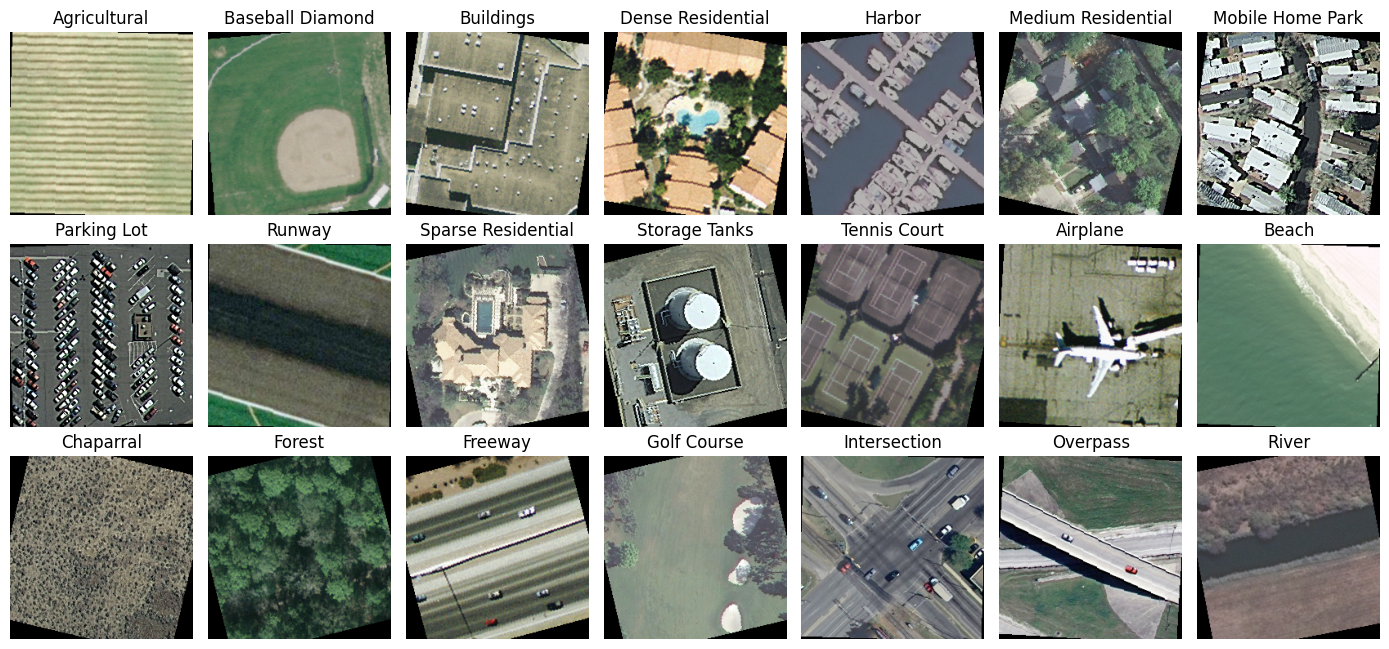

In [7]:
# Display the sample images from train set
helper_utils.show_sample_images(train_dataset, class_names)

## Beyond Shortcuts: The DenseNet Philosophy

In the last lab, you saw how an elegant architectural tweak, the skip connection, created an "express lane" for gradients, allowing you to build deeper networks. But this raises a new question: are we using the information flowing through the network as efficiently as possible?

Each layer in a deep network learns new features, but the rich information from the earliest layers can become diluted as it passes through dozens of transformations. This is especially problematic for a task like yours, where you have **very few training images** for **many distinct classes**. In such a data-scarce environment, your model cannot afford to be redundant. It must squeeze every drop of value from the features it learns to avoid overfitting and generalize effectively.

This is the challenge that the **DenseNet (Densely Connected Convolutional Network)** architecture was designed to solve. It takes the idea of shortcuts to its logical conclusion. Instead of just adding a previous layer's output, DenseNet asks a powerful question: What if every layer was directly connected to *every preceding layer*?

This is achieved by concatenating the feature maps from all previous layers and passing them as input to the current layer. This creates a dense "information highway" where features are explicitly preserved and accumulated throughout the network. This design encourages massive **feature reuse**, which makes the model highly **parameter-efficient** and provides an even stronger solution to the vanishing gradient problem. For your specific challenge, this architecture is an ideal choice, as its data-efficient nature is perfectly suited to learning from a limited number of samples.

**DenseNet** is constructed from three main components:

* **DenseLayer**: A single convolutional layer that produces a small, consistent set of new feature maps (referred to as the `growth_rate`).

* **DenseBlock**: The heart of the architecture; a stack of `DenseLayers` where each layer's output is concatenated with all previous inputs.

* **TransitionLayer**: Connects `DenseBlocks` and handles downsampling to control the feature map size.

You will now build this architecture from the ground up, examining each of these components in detail.



### `DenseLayer`: The Engine of Feature Reuse

The `DenseLayer` is the fundamental building block of the DenseNet. Its design is focused on a single, powerful idea: instead of transforming and replacing information, each layer should add a small, new contribution to a collective bank of knowledge.

To do this without becoming computationally expensive, the `DenseLayer` uses an efficient **bottleneck** strategy to generate a small number of new feature maps. The layer's defining characteristic is how it then integrates these new features with its input, ensuring that all prior information is preserved and carried forward. This process of accumulation is what forms the "information highway."

* **`__init__`**: 
> This constructor defines the two-part structure of the layer.
>    * `dimension_reduction`: This `Sequential` block is the bottleneck. It contains a `BatchNorm`, `ReLU`, and a **1x1 Convolution**. Its sole purpose is to take the potentially large stack of input channels and squeeze them down into a much smaller, manageable number.
>
>    * `feature_extraction`: This second `Sequential` block performs the actual feature learning. It takes the reduced output from the bottleneck and uses a **3x3 Convolution** to generate a small, fixed number of new feature maps, defined by the `growth_rate`.

* **`forward`**: 
> This method defines the data's path and executes the layer's signature logic: aggregating information.
>    1.  **Generate New Features**: The input `x` is first passed through the `dimension_reduction` block and then the `feature_extraction` block. The result is a thin tensor containing only the brand-new features, which we call `new_features`.
>
>    2.  **Aggregate by Concatenation**: This is the pivotal moment. The `new_features` are merged with the original input `x` using `torch.cat`. This operation stacks the new feature maps onto the old ones along the channel dimension.
>        * This step, appending new knowledge instead of transforming old knowledge, is the defining operation of DenseNet. The output of the layer is always thicker than the input, containing a complete record of past and present features.

In [8]:
class DenseLayer(nn.Module):
    """A single dense layer module as described in the DenseNet architecture.

    This layer implements the bottleneck design, where a 1x1 convolution reduces
    the number of feature maps before a 3x3 convolution is applied. The output
    feature maps are then concatenated with the input feature maps.

    Args:
        in_channels (int): The number of **input channels**.
        growth_rate (int): The number of feature maps to produce (**k** in the paper).
        bn_size (int): The multiplicative factor for the number of bottleneck channels.
    """
    def __init__(self, in_channels, growth_rate=32, bn_size=4):
        super(DenseLayer, self).__init__()

        # Bottleneck layer: 1x1 convolution for dimensionality reduction.
        self.dimension_reduction = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False
            ),
        )

        # Feature extraction layer: 3x3 convolution to generate new features.
        self.feature_extraction = nn.Sequential(
            nn.BatchNorm2d(bn_size * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                bn_size * growth_rate,
                growth_rate,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
        )

    def forward(self, x):
        """Defines the forward pass of the dense layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after concatenating with the input.
        """
        # Pass the input through the bottleneck and feature extraction layers.
        new_features = self.dimension_reduction(x)
        new_features = self.feature_extraction(new_features)
        
        # Concatenate the new feature maps with the original input feature maps.
        concatenated_features = torch.cat((x, new_features), 1)

        return concatenated_features

#### Verifying the Blueprint: The `DenseLayer` Summary

You can now visualize the `DenseLayer`'s structure to confirm its internal logic is working exactly as designed. The main goal is to see the signature concatenation operation in action by observing how the number of channels changes.

* Instantiate the `DenseLayer` and define the input dimensions required to generate its blueprint.

In [9]:
# Create an instance of the DenseLayer.
denselayer = DenseLayer(
    in_channels=3,      # Accepts an input with 3 channels (e.g., RGB).
    growth_rate=12,     # Will produce 12 new feature maps.
    bn_size=4           # The bottleneck layer will have (4 * 12) = 48 channels.
)

# Define the shape for a single image (Channels, Height, Width).
img_shape = (3, 64, 64)

# Define the full input shape for a batch of images.
input_size =  (batch_size, *img_shape)

* Run the next cell to display the summary table.

In [10]:
# Define a configuration dictionary to store parameters for the model summary.
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": 2
}

# Generate the model summary object using torchinfo with the specified configuration.
summary = torchinfo.summary(
    model=denselayer, 
    input_size=config["input_size"], 
    col_names=config["attr_names"], 
    depth=config["depth"]
)

# Display the summary as a styled HTML table.
print("--- Model Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Model Summary ---



<br>

This summary provides the proof that your `DenseLayer` is wired correctly. By tracing the `Input Shape` and `Output Shape` through the layer's internal components, you can confirm that the concatenation logic is performing exactly as intended.

A key verification is to follow the number of channels:

* The **bottleneck** (`dimension_reduction`) takes the initial 3 input channels and correctly expands them to **48** channels, which is the result of `bn_size * growth_rate` (4 * 12).

* The `feature_extraction` block then processes these 48 channels to produce the **12** new feature maps defined by the `growth_rate`.

Finally, the total **Output Shape** confirms the core logic: the original **3** channels have been successfully concatenated with the **12** new features to produce a final tensor with **15** channels. Your blueprint is working perfectly.

### `DenseBlock`: Accumulating Knowledge

The `DenseBlock` is the heart of the DenseNet. It acts as a smart container that stacks multiple `DenseLayer`-s, wiring them together in the signature "densely connected" pattern. If a `DenseLayer` is a single sentence contributing a new piece of information, the `DenseBlock` is the paragraph where these sentences are sequentially combined to build a complex idea.

Within the block, the output of one layer, containing all prior features plus its new ones, becomes the direct input for the next. This leads to a systematic growth in the network's collective knowledge, making the feature maps progressively "thicker" as they flow through the block.

* **`__init__`**: 
> This constructor's primary role is to build the stack of `DenseLayers`. It loops for `num_layers` and creates a new `DenseLayer` in each iteration.
>    * The key logic is in calculating the input channels for each new layer: `in_channels + i * growth_rate`. This formula is the mathematical heart of the block, ensuring that each `DenseLayer` is aware of the accumulated feature maps from all the layers that came before it.

* **`forward`**: 
> The forward pass executes the information accumulation. Its logic is straightforward because the complex channel calculations were already handled in the constructor.
>    *  **Initialize Features**: A tensor named `features` is initialized with the block's input, `x`.
>
>    *  **Sequentially Process**: The code iterates through the stack of layers. In each step, the current `features` tensor is passed into a `DenseLayer`, which returns an even thicker tensor (with `growth_rate` new channels). This thicker tensor becomes the new `features` for the next iteration.
>
>    *  **Return Final Output**: After the loop finishes, `features` holds the combined output of all layers in the block, which is then returned.

In [11]:
class DenseBlock(nn.Module):
    """A container for a sequence of DenseLayer modules.

    This class groups multiple DenseLayer instances to form a single "dense block"
    as described in the DenseNet architecture. Within the block, each layer
    receives the feature maps from all preceding layers as its input.

    Args:
        num_layers (int): The number of **DenseLayer** modules in the block.
        in_channels (int): The number of channels in the **input tensor**.
        growth_rate (int): The number of new channels produced by each DenseLayer.
        bn_size (int): The multiplicative factor for the bottleneck layer channels.
    """
    def __init__(self, num_layers, in_channels, growth_rate=32, bn_size=4):
        super(DenseBlock, self).__init__()

        # Initialize a module list to hold all layers in the block.
        self.layers = nn.ModuleList()

        # Sequentially add DenseLayer modules to the block.
        for i in range(num_layers):
            # The input channels for each new layer is the initial number of channels
            # plus the accumulated growth from all previous layers.
            layer = DenseLayer(
                in_channels + i * growth_rate, growth_rate, bn_size
            )
            self.layers.append(layer)

    def forward(self, x):
        """Defines the forward pass for the DenseBlock.

        Args:
            x (torch.Tensor): The input tensor for the block.

        Returns:
            torch.Tensor: The output tensor after passing through all layers.
        """
        # The 'features' tensor holds the concatenated outputs from all layers.
        features = x
        
        # Pass the features through each dense layer in the block.
        for layer in self.layers:
            features = layer(features)
            
        return features

#### Tracing the Knowledge Accumulation

You can now visualize exactly how the number of channels grows as data flows through the `DenseLayer` inside the `DenseBlock`. This will demonstrate the cumulative concatenation that is central to the architecture's design.

* Instantiate the `DenseBlock` itself, configuring it to contain two consecutive `DenseLayer`-s.

In [12]:
# Create an instance of the DenseBlock.
denseblock = DenseBlock(
    in_channels=3,      # The block accepts an input with 3 channels.
    growth_rate=12,     # Each DenseLayer within the block adds 12 channels.
    bn_size=4,          # The bottleneck multiplier used in each DenseLayer.
    num_layers=2,       # The block will contain 2 consecutive DenseLayers.
)

* Run the next cell to display the summary table.

In [13]:
# Define a configuration dictionary to store parameters for the model summary.
config = {
    "input_size": input_size, # (batch_size, *img_shape)
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": 3
}

# Generate the model summary object using torchinfo with the specified configuration.
summary = torchinfo.summary(
    model=denseblock, 
    input_size=config["input_size"], 
    col_names=config["attr_names"], 
    depth=config["depth"]
)

# Display the summary as a styled HTML table.
print("--- Model Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Model Summary ---



<br>

This summary verifies that your `DenseBlock` is correctly stacking `DenseLayer`-s and accumulating features. By tracing the `Output Shape` of each internal layer, you can see the cumulative concatenation in action.

The key is to follow the growth of the channel dimension:

* The block takes an input with **3** channels. The first `DenseLayer` processes this and outputs a tensor with **15** channels (3 + 12).

* This 15-channel tensor is then fed into the second `DenseLayer`, which adds another 12 features, resulting in the block's final output of **27** channels (15 + 12).

This perfectly demonstrates the sequential growth and dense connectivity within the block.

### `TransitionLayer`: The Efficient Bridge

After a `DenseBlock` has diligently accumulated knowledge and created a large, detailed feature map, the `TransitionLayer` steps in to act as a crucial bridge to the next block. If a `DenseBlock` is a dense chapter packed with information, the `TransitionLayer` is the concise summary at the chapter's end, preparing the reader for the next part of the story.

Its purpose is twofold: to **compress** the information (reduce the number of channels) to keep the model efficient, and to **downsample** (reduce the height and width), which helps the network learn more abstract, high-level patterns.

**`__init__`**: 
> The constructor builds a compact and efficient pipeline to perform both compression and downsampling in one go. It bundles these operations into a single `nn.Sequential` module.
>    * The first key piece of logic is calculating the number of output channels: `out_channels = int(in_channels * compression_factor)`. This is the **compression** step, effectively summarizing the vast number of features from the preceding block into a more manageable set.
>    * It then defines the `self.transition` pipeline, which first **stabilizes the incoming features** with `BatchNorm2d` and `ReLU`, and then performs its core tasks:
>
>        * A `1x1 Conv2d` layer to perform the actual channel reduction.
>
>        * An `AvgPool2d` layer with a stride of 2 to cut the feature map's height and width in half, achieving the **downsampling**.

**`forward`**: 
> The forward pass is incredibly straightforward, as all the complex operations were already packaged neatly into the `self.transition` module during initialization.
>    *  **Direct Execution**: It takes the large tensor output from a `DenseBlock` and simply passes it through the pre-built `transition` pipeline.
>
>    *  **Return Final Output**: The layer returns a new tensor that is both "thinner" (fewer channels) and smaller in spatial dimensions, perfectly prepared to be the input for the next `DenseBlock`.

In [14]:
class TransitionLayer(nn.Module):
    """A transition layer used between two dense blocks in a DenseNet.

    This layer is responsible for reducing the number of channels (compression)
    via a 1x1 convolution and downsampling the spatial dimensions of the
    feature maps using average pooling.

    Args:
        in_channels (int): The number of channels in the **input tensor**.
        compression_factor (float): A factor between 0 and 1 to reduce the
                                    number of feature maps.
    """
    def __init__(self, in_channels, compression_factor=0.5):
        super(TransitionLayer, self).__init__()

        # Determine the number of output channels after applying compression.
        out_channels = int(in_channels * compression_factor)

        # The layer consists of batch normalization, a 1x1 convolution for channel
        # reduction, and average pooling for spatial downsampling.
        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        """Defines the forward pass for the transition layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The downsampled and compressed output tensor.
        """
        return self.transition(x)

### `DenseNet`: Assembling the Full Architecture

The `DenseNet` class is the master architect that assembles all the building blocks you have seen, `DenseLayer`, `DenseBlock`, and `TransitionLayer`, into a complete, powerful network. This class is responsible for creating the network's stem, building the main body by correctly stacking and connecting the blocks, and adding the final classification head.

* **`__init__`**: 
> This method acts as the master blueprint for the entire network. It doesn't contain the layer logic itself but calls helper methods to construct the three main parts of the model: the initial feature extractor (`self.features`), the main body of dense blocks and transitions (`self.dense_blocks`), and the final `self.classifier`.

* **`_get_initial_features`**: 
> This helper creates the network's "stem." Its job is to perform an initial, aggressive downsampling of the input image. It uses a standard combination of a large-kernel convolution and max pooling to quickly reduce the spatial dimensions and create the first set of feature maps that will be fed into the main body of the network.

* **`_get_dense_blocks`**: 
> This is the most critical helper method, responsible for building the network's "body." It programmatically constructs the repeating pattern of `DenseBlock` -> `TransitionLayer`.
>    * It iterates through the `block_config` tuple, which defines how many `DenseLayer`-s are in each `DenseBlock`.
>    * A key responsibility of this method is to **track the number of feature maps**. It calculates the channel growth after each `DenseBlock` and the channel compression after each `TransitionLayer`, feeding the correct `in_channels` to the next component.
>
>    * After building the main blocks, it appends the final layers (like `BatchNorm2d` and `AdaptiveAvgPool2d`) that form the "head" of the network, preparing the data for the final classification layer.

* **`forward`**: 
> This method defines the end-to-end journey of the data. The flow is very clean and sequential:
>    *  The input image first passes through the initial `self.features` block.
>
>    *  The resulting feature maps are then passed sequentially through the entire list of `self.dense_blocks` (which contains the alternating `DenseBlock`-s and `TransitionLayer`-s).
>
>    *  Finally, the output is flattened and passed to the `self.classifier` to produce the final predictions.

In [15]:
class DenseNet(nn.Module):
    """
    Implements the DenseNet architecture.

    Args:
        growth_rate (int): The number of feature maps each layer adds.
        block_config (tuple of ints): The number of layers in each dense block.
        num_init_features (int): The number of filters in the initial convolutional layer.
        bn_size (int): The multiplicative factor for the number of bottleneck channels.
        compression_factor (float): The factor by which to reduce the number of channels 
                                    in transition layers.
        num_classes (int): The number of output classes for the final classifier.
    """
    def __init__(
        self,
        growth_rate=32,
        block_config=(6, 12, 24, 16),
        num_init_features=64,
        bn_size=4,
        compression_factor=0.5,
        num_classes=1000,
    ):
        super(DenseNet, self).__init__()

        # Define the initial feature extraction block.
        self.features = self._get_initial_features(num_init_features)

        # Define the main body of the network with the corrected call.
        self.dense_blocks = self._get_dense_blocks(
            num_init_features,
            block_config,
            growth_rate,
            bn_size,
            compression_factor,
        )

        # Define the final fully connected classification layer.
        self.classifier = nn.Linear(self.num_features, num_classes)

    def _get_initial_features(self, num_init_features):
        """
        Creates the initial convolutional block for feature extraction and downsampling.
        
        Args:
            num_init_features (int): The number of output channels for the first convolution.
            
        Returns:
            nn.Sequential: A sequential container for the initial layers.
        """
        # Create a sequential module for the initial layers.
        convolution_block = nn.Sequential(
            # 7x7 convolution with stride 2 for initial downsampling.
            nn.Conv2d(
                3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False
            ),
            # Batch normalization.
            nn.BatchNorm2d(num_init_features),
            # ReLU activation.
            nn.ReLU(inplace=True),
            # 3x3 max pooling with stride 2 for further downsampling.
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        return convolution_block


    def _get_dense_blocks(self, num_init_features, block_config, growth_rate, bn_size, compression_factor):
        """
        Constructs the sequence of dense blocks and transition layers.
        
        Args:
            num_init_features (int): The initial number of features.
            block_config (tuple of ints): The number of layers for each dense block.
            growth_rate (int): The growth rate for dense blocks.
            bn_size (int): The bottleneck size factor.
            compression_factor (float): The compression factor for transition layers.
            
        Returns:
            nn.ModuleList: A list containing the dense blocks, transition layers, 
                           and final classification head components.
        """
        # Create a ModuleList to store all network blocks.
        dense_blocks = nn.ModuleList()
        
        # Initialize the number of features.
        num_features = num_init_features

        # Iterate through the block configurations to build the network.
        for i, num_layers in enumerate(block_config):
            # Create a new DenseBlock.
            db = DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
            )
            # Add the DenseBlock to the list.
            dense_blocks.append(db)

            # Update the number of features based on the growth rate.
            num_features = num_features + num_layers * growth_rate

            # Add a transition layer after each dense block, except for the last one.
            if i != len(block_config) - 1:
                transition = TransitionLayer(
                    in_channels=num_features, compression_factor=compression_factor
                )
                # Add the transition layer to the list.
                dense_blocks.append(transition)
                # Update the number of features after compression.
                num_features = int(num_features * compression_factor)

        # Add the final batch normalization layer.
        dense_blocks.append(nn.BatchNorm2d(num_features))
        # Add the final ReLU activation.
        dense_blocks.append(nn.ReLU(inplace=True))
        # Add global average pooling to create a fixed-size feature vector.
        dense_blocks.append(nn.AdaptiveAvgPool2d((1, 1)))

        # Store the final number of features for the classifier layer.
        self.num_features = num_features
        return dense_blocks

    def forward(self, x):
        """
        Defines the forward pass of the DenseNet model.
        
        Args:
            x (torch.Tensor): The input tensor.
            
        Returns:
            torch.Tensor: The output logits from the classifier.
        """
        # Pass the input through the initial feature extractor.
        x = self.features(x)

        # Pass the features through each block in the main body.
        for block in self.dense_blocks:
            x = block(x)

        # Flatten the output tensor for the fully connected layer.
        x = torch.flatten(x, 1)

        # Pass the flattened features through the classifier.
        x = self.classifier(x)

        return x

#### Assembling the Final Blueprint

With all the individual components built and verified, it's time to assemble the full `DenseNet` model. Generating a summary of the complete architecture allows you to perform a final check, ensuring that the `DenseBlock`-s and `TransitionLayer`-s are connected correctly and that the data dimensions change as expected from the input image to the final feature vector.

* First, create an instance of the complete `DenseNet` model using its default configuration.

In [16]:
# Instantiate the DenseNet model with its default configuration.
densenet = DenseNet()

* Now, run the next cell to generate and display the summary of the full architecture.

In [17]:
# Define a configuration dictionary to store parameters for the model summary.
config = {
    "input_size": input_size, # (batch_size, *img_shape)
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": 2
}

# Generate the model summary object using torchinfo with the specified configuration.
summary = torchinfo.summary(
    model=densenet, 
    input_size=config["input_size"], 
    col_names=config["attr_names"], 
    depth=config["depth"]
)

# Display the summary as a styled HTML table.
print("--- Model Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Model Summary ---



<br>

This summary is the final verification of your complete architecture, showing how all the individual components work together. By tracing the data flow from the initial image to the final prediction, you can confirm that the entire model is assembled correctly.

Here’s what to look for in the summary table:

* **The "Stem" (`features`)**: Observe how the initial block takes the `[3, 64, 64]` input image and performs aggressive downsampling, producing a `[64, 16, 16]` feature map. This is the starting point for the main body of the network.

* **The `DenseBlock` Pattern: Look at the output of each `DenseBlock`. You'll see a massive increase in the number of channels (e.g., from **64** to **256** in the first block). This is the "knowledge accumulation" at work.

* **The `TransitionLayer` Pattern**: After each `DenseBlock`, notice how the `TransitionLayer` performs its two jobs: it compresses the number of channels (e.g., from **256** to **128**) and halves the spatial dimensions (e.g., from `16x16` to `8x8`).

* **The "Head" and `classifier`**: Finally, see how the last few layers (`AdaptiveAvgPool2d`) transform the final feature map into a feature vector of size `[1024, 1, 1]`. This is then flattened and passed to the `classifier` to produce the final `[1000]` output logits.

This confirms that your blueprint has been successfully assembled, with each component performing its specific role in the data's journey through the network.

## Initialize the Training Configurations

You've meticulously built and verified the entire `DenseNet` architecture, from its smallest component to the fully assembled model. With your powerful, data-efficient engine ready, the next step is to prepare it for its mission: learning to classify the land use dataset.

This involves setting up the three core components for any training loop: the model itself, a loss function to measure error, and an optimizer to update the model's weights.

* Instantiate the `DenseNet` model.
    * `num_classes`: Sets the model's final output layer to match the 21 classes in your dataset.

In [18]:
# Set the random seed to ensure that model is always initialized with the same random weights.
torch.manual_seed(SEED)

# Create an instance of your custom DenseNet, configuring the final layer for your specific number of classes.
densenet_model = DenseNet(num_classes=num_classes)

* Define the Loss Function as `nn.CrossEntropyLoss`.
* Define `Adam` with a learning rate of `0.001` as the optimizer.

In [19]:
# Use CrossEntropyLoss as loss function
loss_function = nn.CrossEntropyLoss()

# Use Adam with lr=0.001
optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)

## Training and Validation

You are now ready to put your custom-built architect to the test. You will train the model using the provided `training_loop_16_mixed` function, which handles the complete training and validation cycle using an efficient **16-bit mixed-precision** strategy.

The function will track performance and return the three key results from the training run:

* `model`: The trained model itself, loaded with the weights from the epoch that achieved the **highest validation accuracy**. This ensures you are working with the best version of your model.

* `history`: A dictionary that records the performance metrics (`train_loss`, `val_loss`, `val_accuracy`) for each epoch.

* `best_cm`: The confusion matrix calculated on the validation data from the **best-performing epoch**. This provides a detailed snapshot of the model's performance at its peak.

* Feel free to set a different value for `num_epochs`. Since **DenseNet** is a deep architecture and you are training on a dataset with limited images per class, it may take more epochs to converge. A range of **20-25** should be sufficient to see good results. The value is currently set to **20**.

In [20]:
# Define the total number of full training cycles (epochs) to run.
num_epochs = 20

In [21]:
# Launch the training process for the custom-built DenseNet model.
trained_densenet, history, confusion_matrix = helper_utils.training_loop_16_mixed(
    model=densenet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    save_path='./saved_models/best_trained_densenet.pth',
)

Overall Progress:   0%|          | 0/1340 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 2.3306, Val Loss: 2.7084, Val Acc: 0.2544
  -> New best model saved to './saved_models/best_trained_densenet.pth' with Val Acc: 25.44%

Epoch 2/20 - Train Loss: 1.9447, Val Loss: 1.9307, Val Acc: 0.3775
  -> New best model saved to './saved_models/best_trained_densenet.pth' with Val Acc: 37.75%

Epoch 3/20 - Train Loss: 1.7540, Val Loss: 2.1740, Val Acc: 0.3296
Epoch 4/20 - Train Loss: 1.6573, Val Loss: 1.8293, Val Acc: 0.4193
  -> New best model saved to './saved_models/best_trained_densenet.pth' with Val Acc: 41.93%

Epoch 5/20 - Train Loss: 1.5989, Val Loss: 1.5619, Val Acc: 0.4511
  -> New best model saved to './saved_models/best_trained_densenet.pth' with Val Acc: 45.11%

Epoch 6/20 - Train Loss: 1.4794, Val Loss: 1.6724, Val Acc: 0.5251
  -> New best model saved to './saved_models/best_trained_densenet.pth' with Val Acc: 52.51%

Epoch 7/20 - Train Loss: 1.3597, Val Loss: 1.2923, Val Acc: 0.5629
  -> New best model saved to './saved_models/best_trained_den

### Visualizing Performance

To better understand the model's learning journey toward its peak performance, you can now plot the metrics from the `history` object. The learning curves will visually confirm the analysis, showing the steady decrease in loss and the corresponding rise in accuracy across the training epochs.

---------- Best Epoch Performance ----------
Model: Custom DenseNet
Epoch: 20
Validation Accuracy: 75.70%
Validation Loss:     0.7884
------------------------------------------



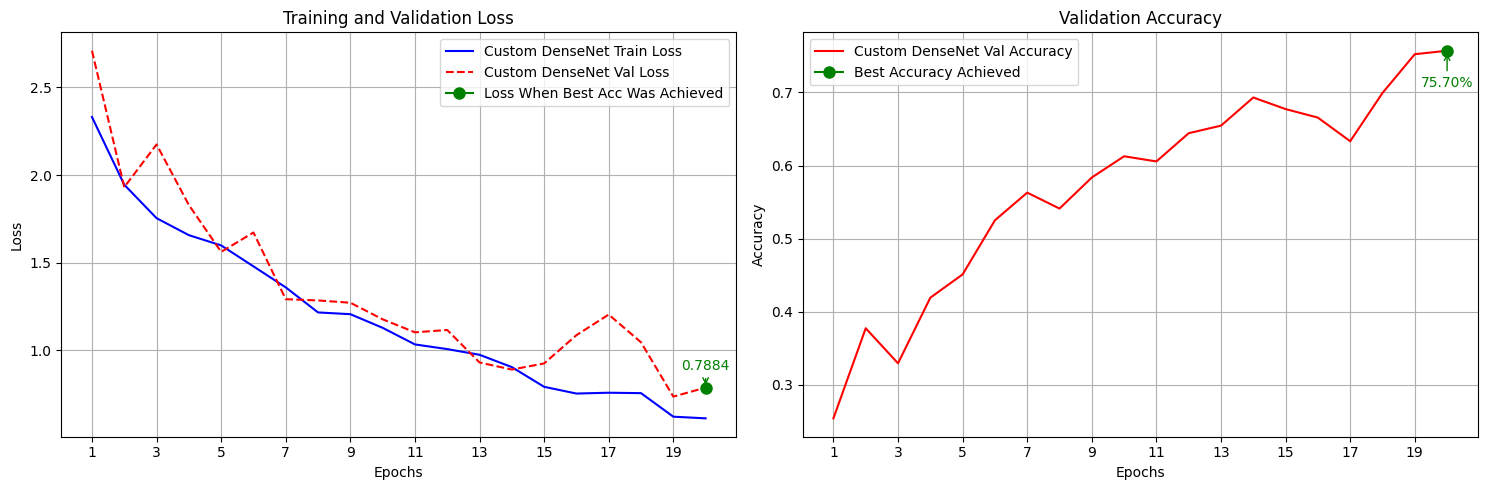

In [22]:
# Plot the learning curves to visualize the model's performance and highlight the best epoch.
helper_utils.plot_training_history(history)

<br>

**The Architect's Success: Analyzing the Performance**

The training results are in, and they are a clear testament to the power of the **DenseNet** architecture you built. Achieving a decent validation accuracy (>=**75%**) on a challenging 21-class dataset, with only **100** images per class and training from scratch, is a remarkable achievement.

Let's break down what these plots tell you:

* **Training and Validation Loss**: The plot on the left shows a healthy learning process. The **training loss** (blue) consistently decreases as the model learns from the data. Crucially, the **validation loss** (red) also follows a strong downward trend, which indicates that the model is generalizing well to unseen images and is not simply memorizing the training set.

* **Validation Accuracy**: The plot on the right tells an even clearer story of success. The steady and significant climb in accuracy demonstrates that your model progressively learned the subtle visual cues needed to distinguish between difficult classes like `harbor`, `mediumresidential`, and `tenniscourt`.

**Why Did This Work So Well?**

This strong performance is not a coincidence; it is a direct result of the intelligent design of **DenseNet** that you implemented:

* **Massive Feature Reuse**: On a data-scarce problem like this, a traditional network would struggle with overfitting. Your **DenseNet**, however, excelled because its architecture is inherently data-efficient. By concatenating feature maps from all preceding layers, the model is forced to reuse and build upon existing knowledge rather than re-learning features from scratch. It squeezes the maximum value out of every training sample.

* **Strong Gradient Flow**: The dense "information highway" ensures that the learning signal (gradient) can flow directly and deeply through the network. This prevents the learning process from stalling and allows the entire model to train effectively.

## Visualizing Predictions and Confusion Matrix

The learning curves and peak accuracy score give you a strong quantitative measure of your model's success. However, to get a true qualitative feel for its capabilities, it is invaluable to see it in action.

Visualizing predictions on individual images shows you not just *that* the model is working, but *how* it is performing on different classes. This is where you can see what your model gets right and, more importantly, where it might be making mistakes.

* First, you will visualize predictions from your `trained_densenet` to see how it performs on the various land use types.

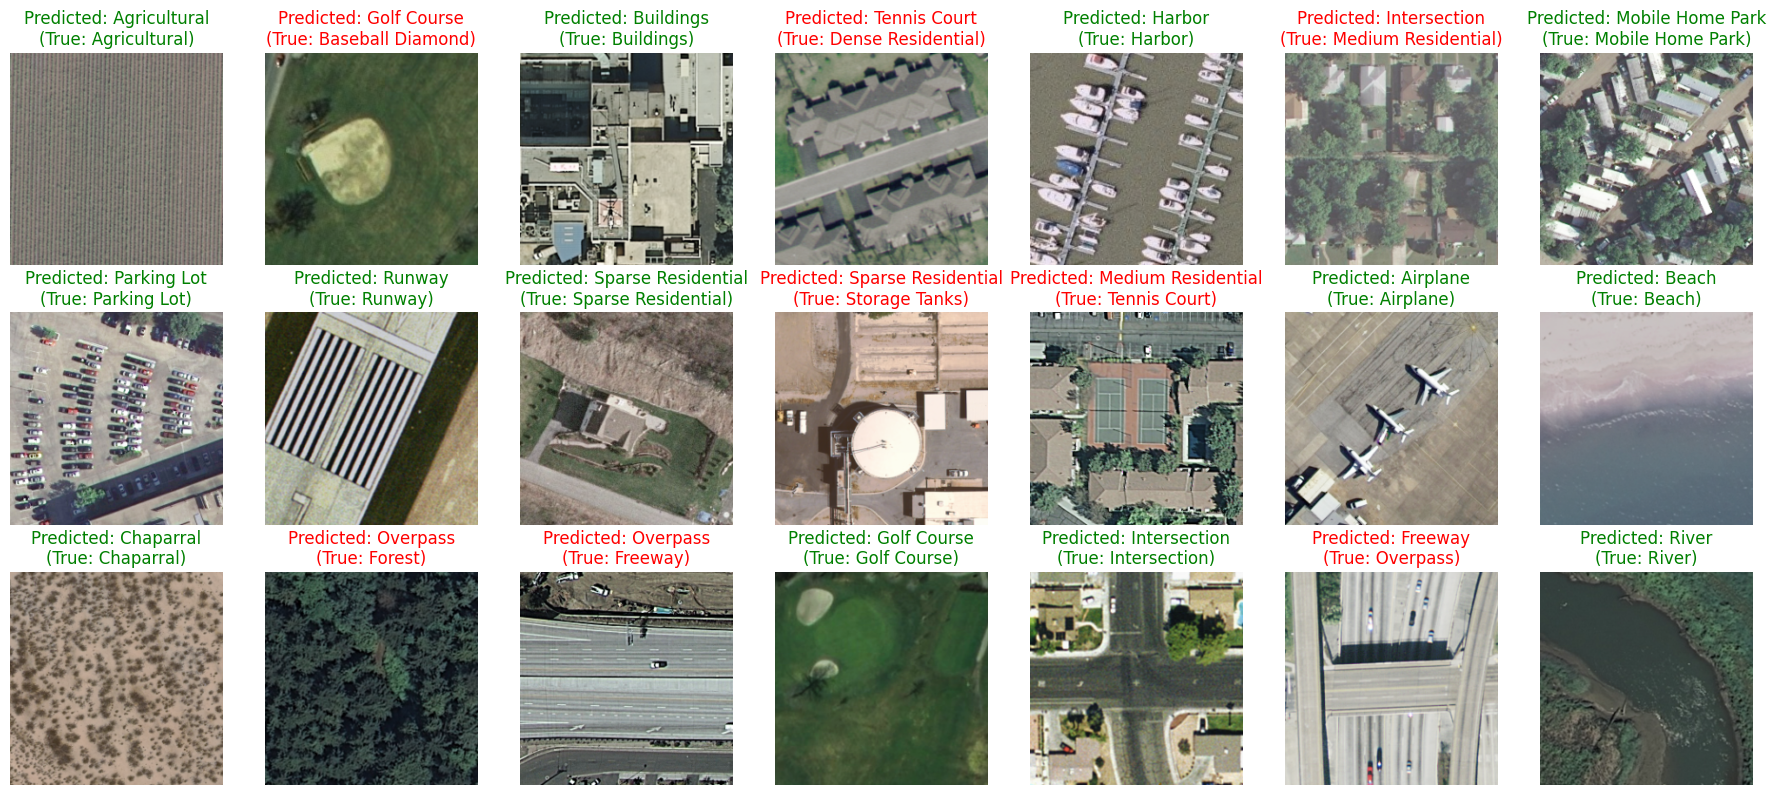

In [23]:
# Visualize the performance of the trained DenseNet by plotting its predictions on a sample of images from the validation set.
helper_utils.visualize_predictions(trained_densenet, val_loader, class_names, device)

<br>

The overall accuracy score confirms that your custom **DenseNet** successfully tackled the challenge of learning from a scarce dataset. Now you can dig deeper to see how its data-efficient design translated into specific successes.

A **confusion matrix** is the perfect tool for this analysis. It will show you precisely which of the 21 classes the model mastered and which ones it found more challenging. This is where you can see if the model's feature reuse was effective enough to learn the subtle differences between visually similar categories, like different housing densities or types of infrastructure.

* Plot the confusion matrix from the model's best epoch to get a detailed report card of its performance.

--- Per-Class Accuracy ---


Calculating Metrics:   0%|          | 0/21 [00:00<?, ?it/s]

Agricultural         | Accuracy: 95.45%
Baseball Diamond     | Accuracy: 92.86%
Buildings            | Accuracy: 55.56%
Dense Residential    | Accuracy: 65.22%
Harbor               | Accuracy: 80.00%
Medium Residential   | Accuracy: 65.00%
Mobile Home Park     | Accuracy: 68.75%
Parking Lot          | Accuracy: 100.00%
Runway               | Accuracy: 95.45%
Sparse Residential   | Accuracy: 90.91%
Storage Tanks        | Accuracy: 35.29%
Tennis Court         | Accuracy: 28.57%
Airplane             | Accuracy: 88.00%
Beach                | Accuracy: 100.00%
Chaparral            | Accuracy: 94.44%
Forest               | Accuracy: 72.73%
Freeway              | Accuracy: 72.22%
Golf Course          | Accuracy: 83.33%
Intersection         | Accuracy: 92.31%
Overpass             | Accuracy: 55.17%
River                | Accuracy: 58.33%
----------------------------------------



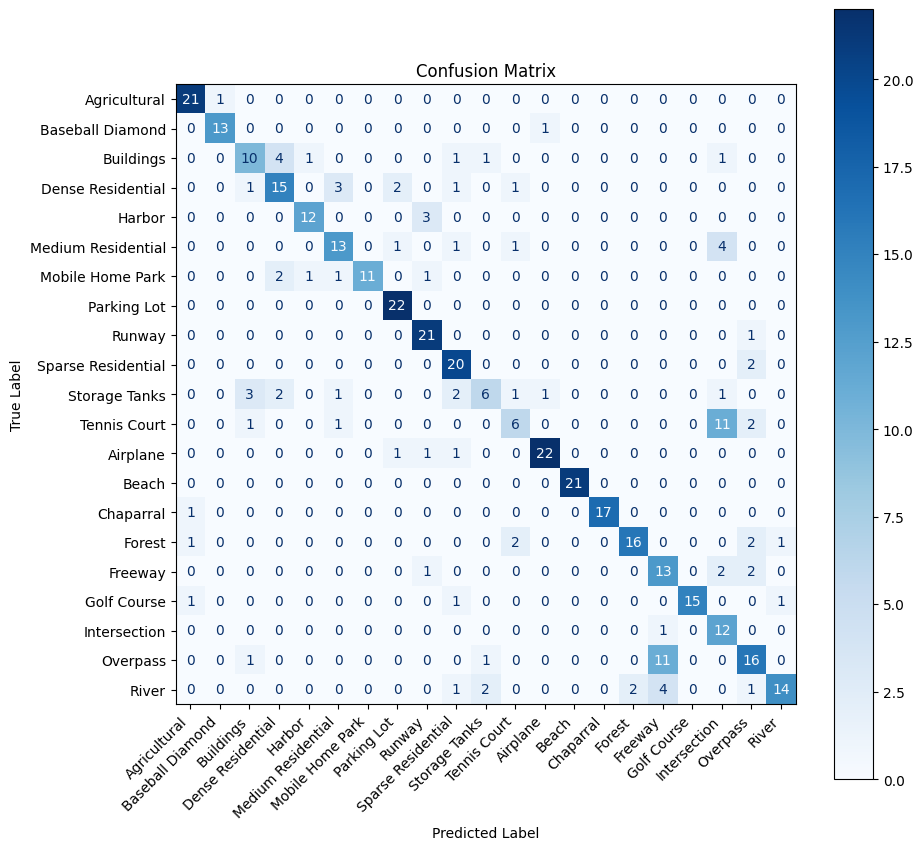

In [24]:
# Plot the confusion matrix to visualize the model's class-by-class performance.
helper_utils.plot_confusion_matrix(confusion_matrix, class_names)

<br>

This detailed breakdown is a clear success, confirming that your custom-built **DenseNet** learned effectively despite the challenging, data-scarce nature of the dataset.

The strong diagonal line in the confusion matrix shows that the model correctly classifies most images. It performs exceptionally well on classes with distinct structures, like `Baseball Diamond`, `Harbor`, and `Mobile Home Park`. This is a testament to the power of **DenseNet's** feature reuse; even with few examples, the model learned a rich set of features to identify these unique patterns.

The matrix is also a valuable diagnostic tool, highlighting the subtle challenges of the task. As you might expect, the model occasionally confuses classes that are visually similar from an aerial view. For instance, it can be difficult to distinguish between different residential densities or to separate large green areas like a `Golf Course` from `Agricultural` land. This is a common challenge in geospatial analysis and provides a great insight into where the model could be improved with more data or further training.

This entire process, from designing the architecture to training and analyzing it, gives you a deep and thorough understanding of how **DenseNet** works. You've proven that its data-efficient design is highly effective.

However, in many real-world projects, you don't need to build and train these complex architectures from scratch. Just as you've seen with other famous architectures, the Torchvision library provides a `densenet` model that has already been trained on millions of images. Let's explore how you can leverage this powerful, pre-trained tool to achieve even better results with a fraction of the effort.

## The Professional's Shortcut: Feature Extraction

As you saw from training your custom model, achieving high accuracy from scratch is a slow and computationally intensive process. After **20 epochs**, your model reached an impressive validation accuracy of around **78%**. While this is a great result, it required significant training time.

Fortunately, instead of starting from zero, you can benefit from **feature extraction** by using the [densenet121](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html) model directly from Torchvision models library, which has been trained on a massive dataset (like ImageNet). Since this model is already an expert at recognizing a vast library of visual features, you can **freeze** its pre-trained layers and simply replace the final **classifier head** with a new one suited for your 21 classes. By training only this small, new layer, you can achieve excellent results in just a few epochs.

* Run the next cell to load the pretrained **densenet121** model.

In [25]:
# Load the pre-trained DenseNet-121 model and configure it for feature extraction.
pretrained_densenet = helper_utils.load_pretrained_densenet(
    num_classes=num_classes,
    weights_path="./pretrained_densenet_weights/densenet121-a639ec97.pth",
    train_classifier_only=True,
    seed=SEED                  
)

* Define a new optimizer for the pretrained `densenet121`.

In [26]:
# Pass only the parameters of the new, trainable classifier head to the optimizer.
optimizer_pretrained = optim.Adam(
    (p for p in pretrained_densenet.parameters() if p.requires_grad), 
    lr=0.001
)

* Feel free to set a different value for `num_epochs`. Since you are only training a small classifier head on top of a powerful pre-trained base, the model learns extremely quickly. You will find that **5** epochs are more than enough to achieve a very high validation accuracy.

In [27]:
# Set the number of training epochs. A small number is sufficient for feature extraction.
num_epochs = 5

* Run the next cell to begin feature extraction by training the new classifier head.

In [28]:
# Launch the feature extraction process for the pre-trained DenseNet.
feature_extracted_densenet, history, cm_feature_densenet = helper_utils.training_loop_16_mixed(
    model=pretrained_densenet,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer_pretrained,
    num_epochs=num_epochs,
    device=device,
    save_path='./saved_models/best_pretrained_densenet.pth',
)

Overall Progress:   0%|          | 0/335 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 2.2726, Val Loss: 1.5374, Val Acc: 0.7010
  -> New best model saved to './saved_models/best_pretrained_densenet.pth' with Val Acc: 70.10%

Epoch 2/5 - Train Loss: 1.1581, Val Loss: 0.9288, Val Acc: 0.8572
  -> New best model saved to './saved_models/best_pretrained_densenet.pth' with Val Acc: 85.72%

Epoch 3/5 - Train Loss: 0.7801, Val Loss: 0.7057, Val Acc: 0.8807
  -> New best model saved to './saved_models/best_pretrained_densenet.pth' with Val Acc: 88.07%

Epoch 4/5 - Train Loss: 0.5769, Val Loss: 0.6352, Val Acc: 0.8637
Epoch 5/5 - Train Loss: 0.5035, Val Loss: 0.5072, Val Acc: 0.9091
  -> New best model saved to './saved_models/best_pretrained_densenet.pth' with Val Acc: 90.91%


Best model saved to './saved_models/best_pretrained_densenet.pth' with accuracy 90.91%


### Visualizing Predictions and Confusion Matrix

* Run the next cell to plot predictions made by the `feature_extracted_densenet`.

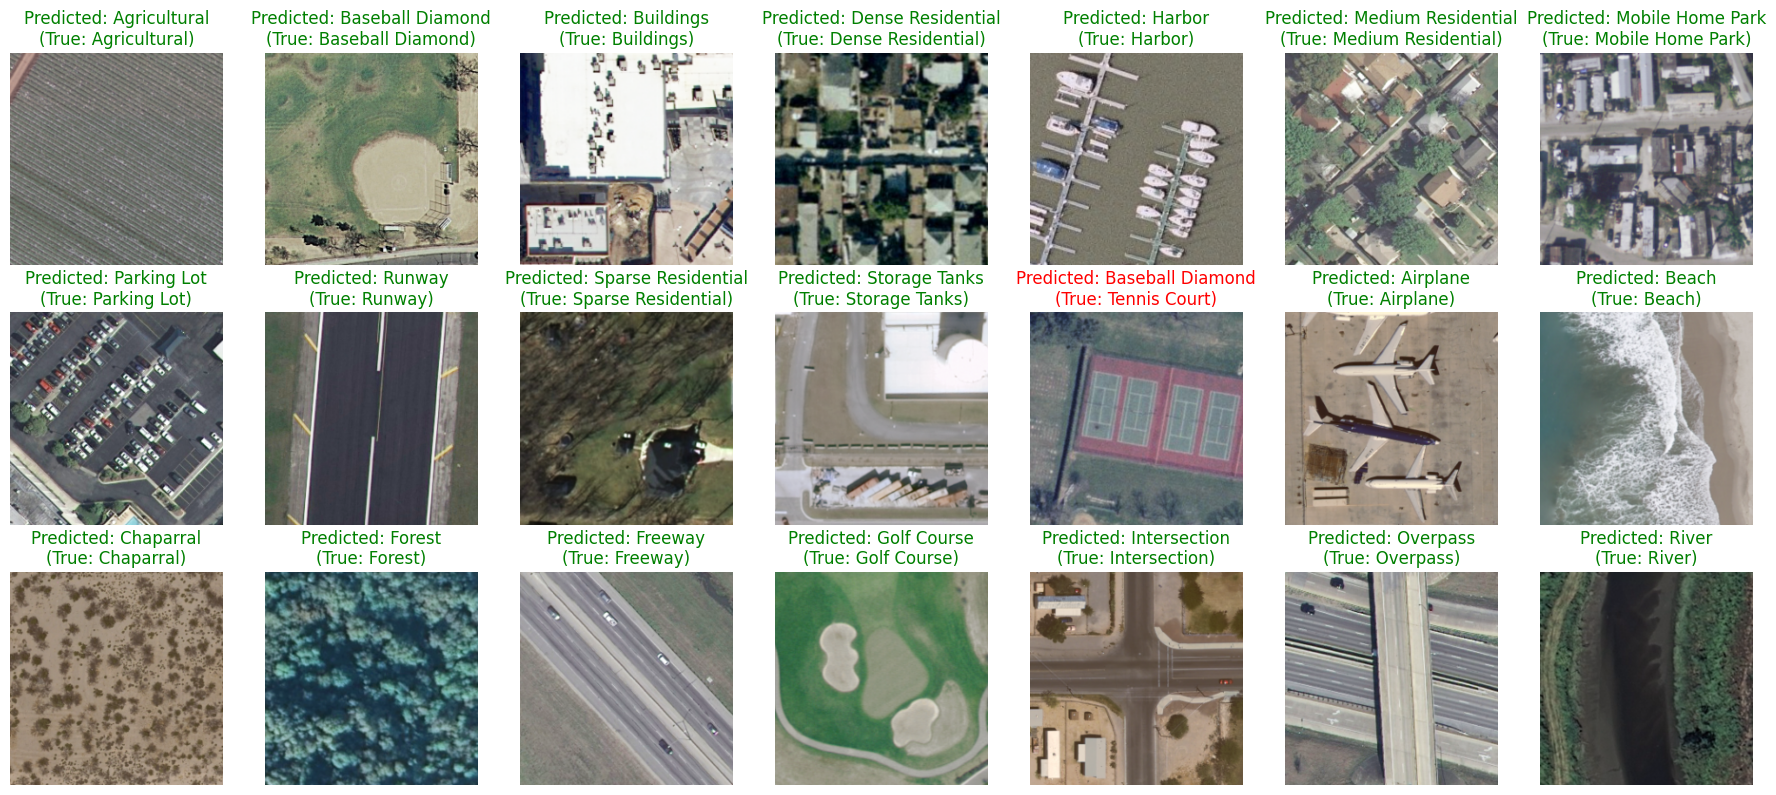

In [29]:
# Visualize predictions from the feature-extracted model on a sample of validation images.
helper_utils.visualize_predictions(feature_extracted_densenet, val_loader, class_names, device)

* Run the next cell to plot the confusion matrix for the `feature_extracted_densenet`.

--- Per-Class Accuracy ---


Calculating Metrics:   0%|          | 0/21 [00:00<?, ?it/s]

Agricultural         | Accuracy: 100.00%
Baseball Diamond     | Accuracy: 100.00%
Buildings            | Accuracy: 77.78%
Dense Residential    | Accuracy: 69.57%
Harbor               | Accuracy: 100.00%
Medium Residential   | Accuracy: 90.00%
Mobile Home Park     | Accuracy: 100.00%
Parking Lot          | Accuracy: 95.45%
Runway               | Accuracy: 90.91%
Sparse Residential   | Accuracy: 86.36%
Storage Tanks        | Accuracy: 94.12%
Tennis Court         | Accuracy: 61.90%
Airplane             | Accuracy: 88.00%
Beach                | Accuracy: 100.00%
Chaparral            | Accuracy: 100.00%
Forest               | Accuracy: 100.00%
Freeway              | Accuracy: 88.89%
Golf Course          | Accuracy: 100.00%
Intersection         | Accuracy: 100.00%
Overpass             | Accuracy: 82.76%
River                | Accuracy: 83.33%
----------------------------------------



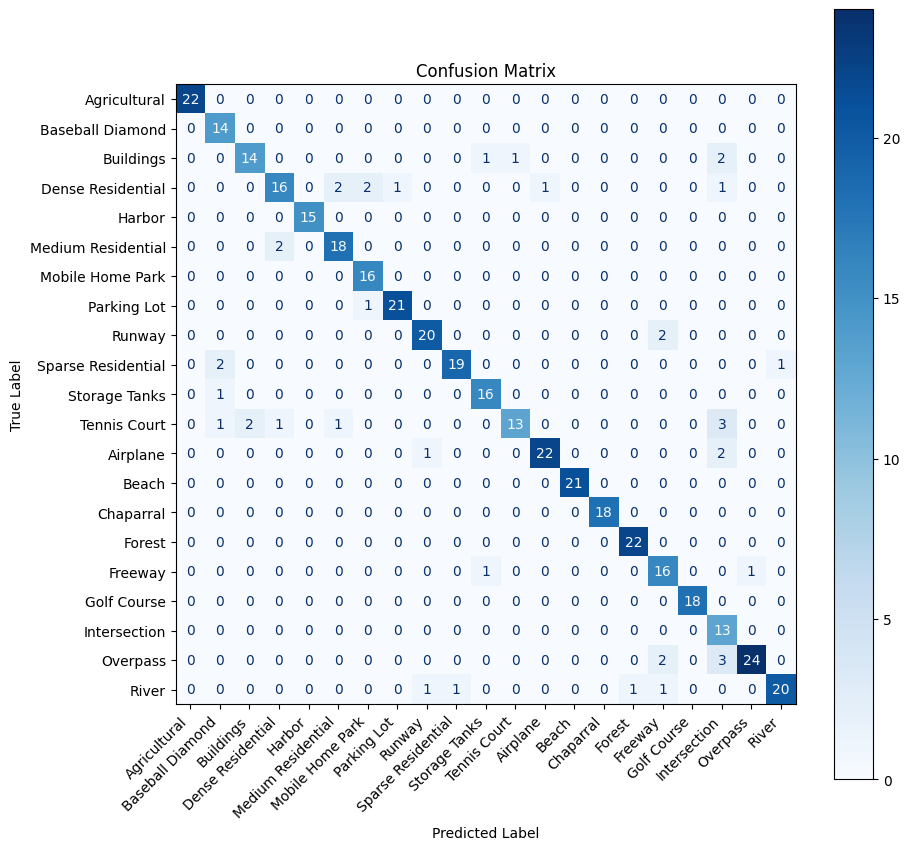

In [30]:
# Plot the confusion matrix to visualize the model's class-by-class performance.
helper_utils.plot_confusion_matrix(cm_feature_densenet, class_names)

<br>

The results from feature extraction are a dramatic showcase of the power and efficiency of transfer learning. The confusion matrix reveals an exceptionally strong diagonal line, and the per-class accuracies are outstanding across the board.

This is the key takeaway: in just **5 epochs**, by training only a tiny fraction of the network's parameters, you have significantly surpassed the performance of your custom-built model that trained for 20 epochs. The model achieved near-perfect accuracy on many classes and showed marked improvement on visually similar categories that were previously challenging.

This remarkable performance is possible because the model didn't start from scratch. It leveraged a vast library of features learned from the massive ImageNet dataset, and you simply guided its expert knowledge toward your specific land use problem. This is the essence of a modern, efficient deep learning workflow: standing on the shoulders of giants to achieve state-of-the-art results with a fraction of the effort.

## Conclusion

You began this journey by understanding the need to move beyond simple, linear models and take direct control over your network's data flow. This lab put that theory into practice. You explored **DenseNet**'s powerful approach to feature reuse, which, instead of adding connections like ResNet, concatenates feature maps from all preceding layers to create a dense "information highway".

Building the model from scratch gave you a firsthand look at advanced architectural patterns. You used modular design to create reusable components and saw how `nn.ModuleList` enables dynamic model creation, allowing you to programmatically construct `DenseBlock`-s with a variable number of layers. The strong performance of your custom model on a data-scarce problem was a clear testament to the architecture's inherent data efficiency.

Finally, you transitioned from architect to practitioner by applying the professional's shortcut: **transfer learning**. By freezing the pre-trained feature extractor and training only a new classifier head, you achieved superior results in a fraction of the time. This demonstrated that a deep understanding of an architecture's design is most powerful when combined with a strategic approach to leveraging existing knowledge. You've successfully designed, built, and applied a modern, state-of-the-art architecture to solve a complex problem efficiently.